# Packages

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, MultiPolygon, Polygon, LineString
from shapely.ops import nearest_points
%matplotlib inline
import time
import folium
from vincenty import vincenty

# Load coastline shape file

In [2]:
# Coastline can be downloaded here: https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/
# load coastline: WGS84 format
df_coastline = gpd.read_file('../data/ne_10m_coastline/ne_10m_coastline.shp')
# transform it to Web Mercator projection
df_coastline_mercator = df_coastline.to_crs('EPSG:3857')
# can be stored in mercator format: df_coastline_mercator.to_file("coast_mercator.shp")
df_coastline.head()

,featurecla,scalerank,min_zoom,geometry
0,Coastline,0,0.0,"LINESTRING (59.91603 -67.40049, 59.67856 -67.3..."
1,Coastline,0,0.0,"LINESTRING (-51.73062 -82.06260, -52.18688 -82..."
2,Coastline,6,5.0,"LINESTRING (166.13697 -50.86435, 166.10711 -50..."
3,Coastline,0,0.0,"LINESTRING (-56.66832 -36.73642, -56.66487 -36..."
4,Coastline,0,0.0,"LINESTRING (-51.07939 3.49209, -51.09648 3.449..."


<Axes: >

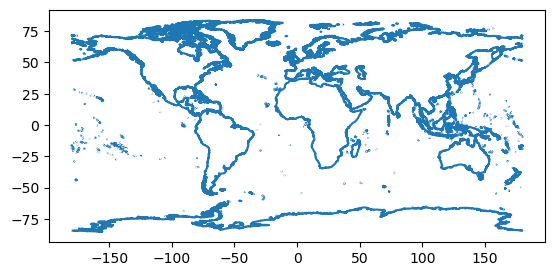

In [3]:
df_coastline.plot()

# Compute distance to coast on an example

In [4]:
vessel_pos = [38.675436, -11.791253] # test position
point = Point(vessel_pos[::-1])

# Transform to mercator projection
point_df_mercator = gpd.GeoDataFrame({'geometry': [point]}, crs='EPSG:4326')
point_df_mercator = point_df_mercator.to_crs(3857)
point_mercator = point_df_mercator['geometry'].values[0]

In [5]:
# compute distances from point to coastline using mercator format (euclidean distances)
df_distances = df_coastline_mercator.distance(point_mercator)

C:\Users\OlivierIsson\anaconda3\lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [6]:
# find coast nearset point
nr_pts = nearest_points(df_coastline_mercator.loc[df_distances.argmin(),'geometry'], point_df_mercator['geometry'].values[0])

In [7]:
# convert obtained point to WGS84 format
points_df = gpd.GeoDataFrame({'geometry': nr_pts}, crs='EPSG:3857')
points_df = points_df.to_crs(4326)
coast_point = [points_df['geometry'].values[0].xy[1][0], points_df['geometry'].values[0].xy[0][0]]


In [8]:
points_df

,geometry
0,POINT (-9.49747 38.78823)
1,POINT (-11.79125 38.67544)


In [9]:
# Plot in a map the vessel position and the calculated coast point 
m = folium.Map(location=vessel_pos, tiles="OpenStreetMap", zoom_start=6)
folium.Marker(
      location=coast_point,
   ).add_to(m)
folium.Marker(
      location=vessel_pos,
   ).add_to(m)
my_PolyLine=folium.PolyLine(locations=[coast_point, vessel_pos],weight=5)
m.add_child(my_PolyLine)
folium.Marker(
      location=vessel_pos,
      icon=folium.DivIcon(html=f"""<div style="font-family: courier new; color: blue">{'Vessel'}</div>""")
   ).add_to(m)

m

In [10]:
# compute distances using Vincenty 
vincenty(vessel_pos, coast_point, miles=False)

199.83771

# Distance to coast function

In [11]:
def distance_to_coast(df_coastline_mercator, vessel_pos):
    
    # Transform to mercator projection
    point_df_mercator = gpd.GeoDataFrame({'geometry': [point]}, crs='EPSG:4326')
    point_df_mercator = point_df_mercator.to_crs(3857)
    point_mercator = point_df_mercator['geometry'].values[0]
    
    # compute distances from point to coastline using mercator format (euclidean distances)
    df_distances = df_coastline_mercator.distance(point_mercator)
    
    # find coast nearset point
    nr_pts = nearest_points(
        df_coastline_mercator.loc[df_distances.argmin(),'geometry'],
        point_mercator
    )
    
    # convert obtained point to WGS84 format
    points_df = gpd.GeoDataFrame({'geometry': nr_pts}, crs='EPSG:3857')
    points_df = points_df.to_crs(4326)
    coast_point = [
        points_df['geometry'].values[0].xy[1][0],
        points_df['geometry'].values[0].xy[0][0]
    ]
    
    vincenty_distance = vincenty(vessel_pos, coast_point, miles=False)
    
    return  coast_point, vincenty_distance

# Estimate run time for distance to coast estimation

In [12]:
t0 = time.time()
print(distance_to_coast(df_coastline_mercator, vessel_pos))
print(time.time() - t0)

([38.788234768000045, -9.497466600999926], 199.83771)
0.051095008850097656


C:\Users\OlivierIsson\anaconda3\lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
